## Transition indicators (TIs)

The present notebook aims to provide exemplary computation of TIs. Therefore, two systems are studied:
1. a linear system (therefore incapable of undergoing critical transitions) to test the presence of false positives.
2. a nonlinear system representing a 1D double-well that undergoes a critical transition to test true positives.

First we load the packages and self-written functions:

In [43]:
using DrWatson
@quickactivate "StatisticalEWS"

using LinearAlgebra, BenchmarkTools, RollingFunctions
using Statistics, StatsBase, Random, Distributions
using CairoMakie, DifferentialEquations, FFTW, CUDA

include(srcdir("utils.jl"))
include(srcdir("ews.jl"))
include(srcdir("stattest.jl"))

check_std_endpoint (generic function with 1 method)

#### Model definition

We let both aforementioned models be forced by a user-defined function. In the present case, this is a simple linear drift such that the double-well model is driven out of its original equilibrium (i.e. experiences a transition).

In [17]:
# Deterministic part of linear system.
function f_linear(dx, x, p, t)
    dx[1] = p["λ"] * (x[1] + 1) + forcing(p, t)
end

# Deterministic part of double-well system.
function f_doublewell(dx, x, p, t)
    dx[1] = -x[1]^3 + x[1] + forcing(p, t)
end

# Stochastic part of system for noise.
function g_whitenoise(dx, x, p, t)
    dx[1] = p["σ"]
end

function forcing(p, t)
    return p["α"] * t
end

forcing (generic function with 1 method)

#### Perform simulation

In [18]:
# Define time step, vector and span. IC set for equilibrium of both systems.
dt = 1f-2
t = collect(0f0:dt:10f0)
tspan = extrema(t)
x0 = [-1f0]

pmodel = Dict("σ" => .1f0, "λ" => -1f0, "α" => .1f0)
models = [f_linear, f_doublewell]
labels = ["linear", "doublewell"]
nmodels = length(models)
X = zeros(Float32, nmodels, length(t))

for (f, lbl, i) in zip(models, labels, 1:nmodels)
    prob = SDEProblem(f, g_whitenoise, x0, tspan, pmodel)
    sol = solve(prob, EM(), dt=dt)
    X[i, :] = vcat(sol.u...)
end

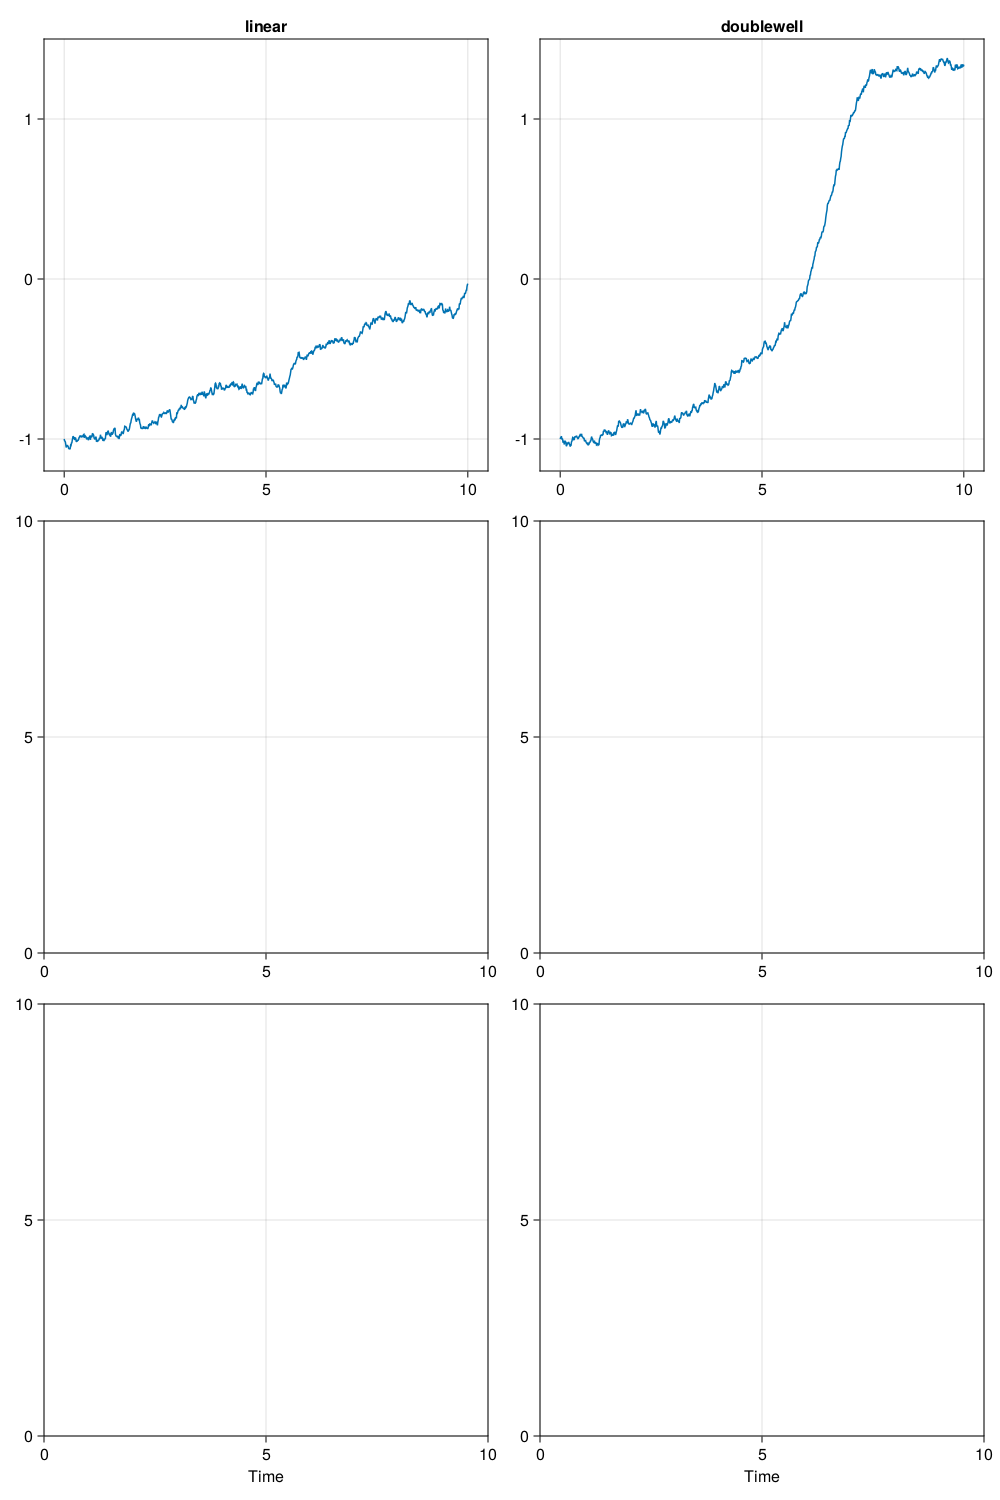

In [19]:
nrows, ncols = 3, nmodels
fig = Figure( resolution = (1000, 1500) )
axs = [[Axis(
    fig[i,j],
    title = ( i==1 ? labels[j] : " "),
    xlabel = ( i==nrows ? "Time" : " "),
    ) for j in 1:ncols] for i in 1:nrows]

[lines!(axs[1][i], t, X[i, :], label = "data") for i in 1:ncols]
[ylims!(axs[1][i], (-1.2, 1.5)) for i in 1:ncols]
fig

#### Detrend time series

In order to obtain the noise response, the time series is detrended. For this, several algorithms can be used:
- Rolling average
- Gaussian kernel
- Butterworth filter
- More to come...

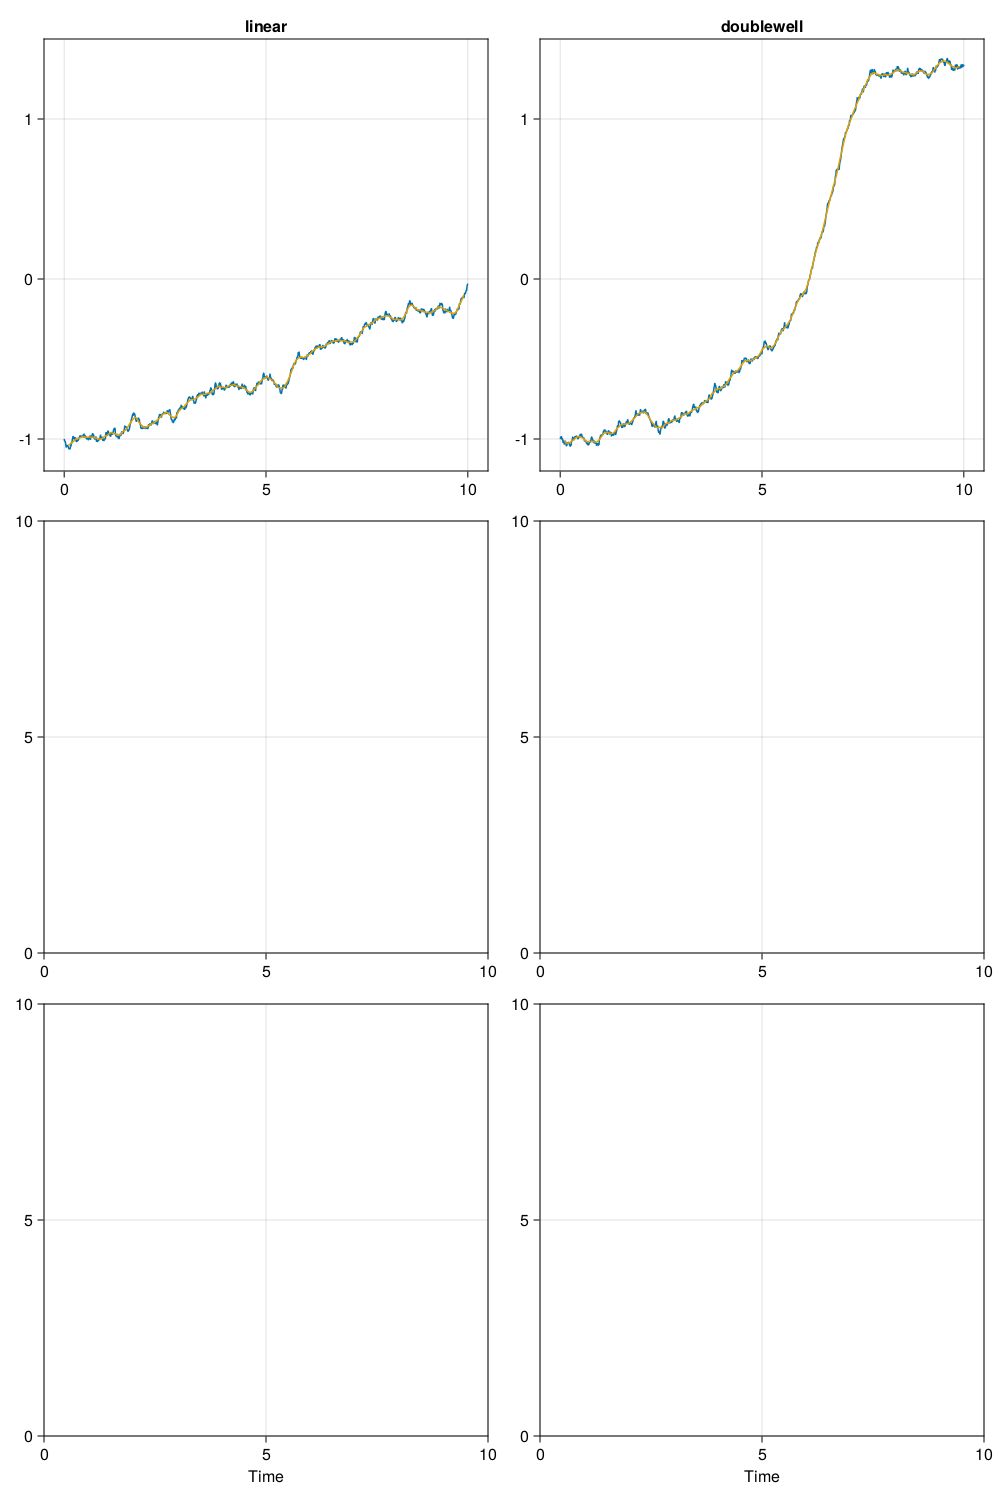

In [20]:
Tsmooth = 1f-1          # half-width for smoothing window .
Tindctr = 5f-1          # half-width for computation of indicator.
Tsignif = 1f0           # half-width for computation of indicator significance.
Tstride = 2f-1          # stride for computation of indicator.
T = [dt, Tsmooth, Tindctr, Tsignif, Tstride]
N = get_step.(T[2:end], dt)
pwin = WindowingParams(T..., N...)
window = centered_window
trend = gettrend_rollmean

Xtrend = mapslices( x_ -> trend(x_, pwin.Nsmooth), X; dims=2 )
[lines!(axs[1][i], t, Xtrend[i, :], label = "trend") for i in 1:nmodels]
fig

#### Compute exemplary TIs

The most commonly used TIs are the variance and the coefficient of an AR1 regression of the residual. They are both expected to increase whenever a critical transition is near. Let's compute them and see what happens!

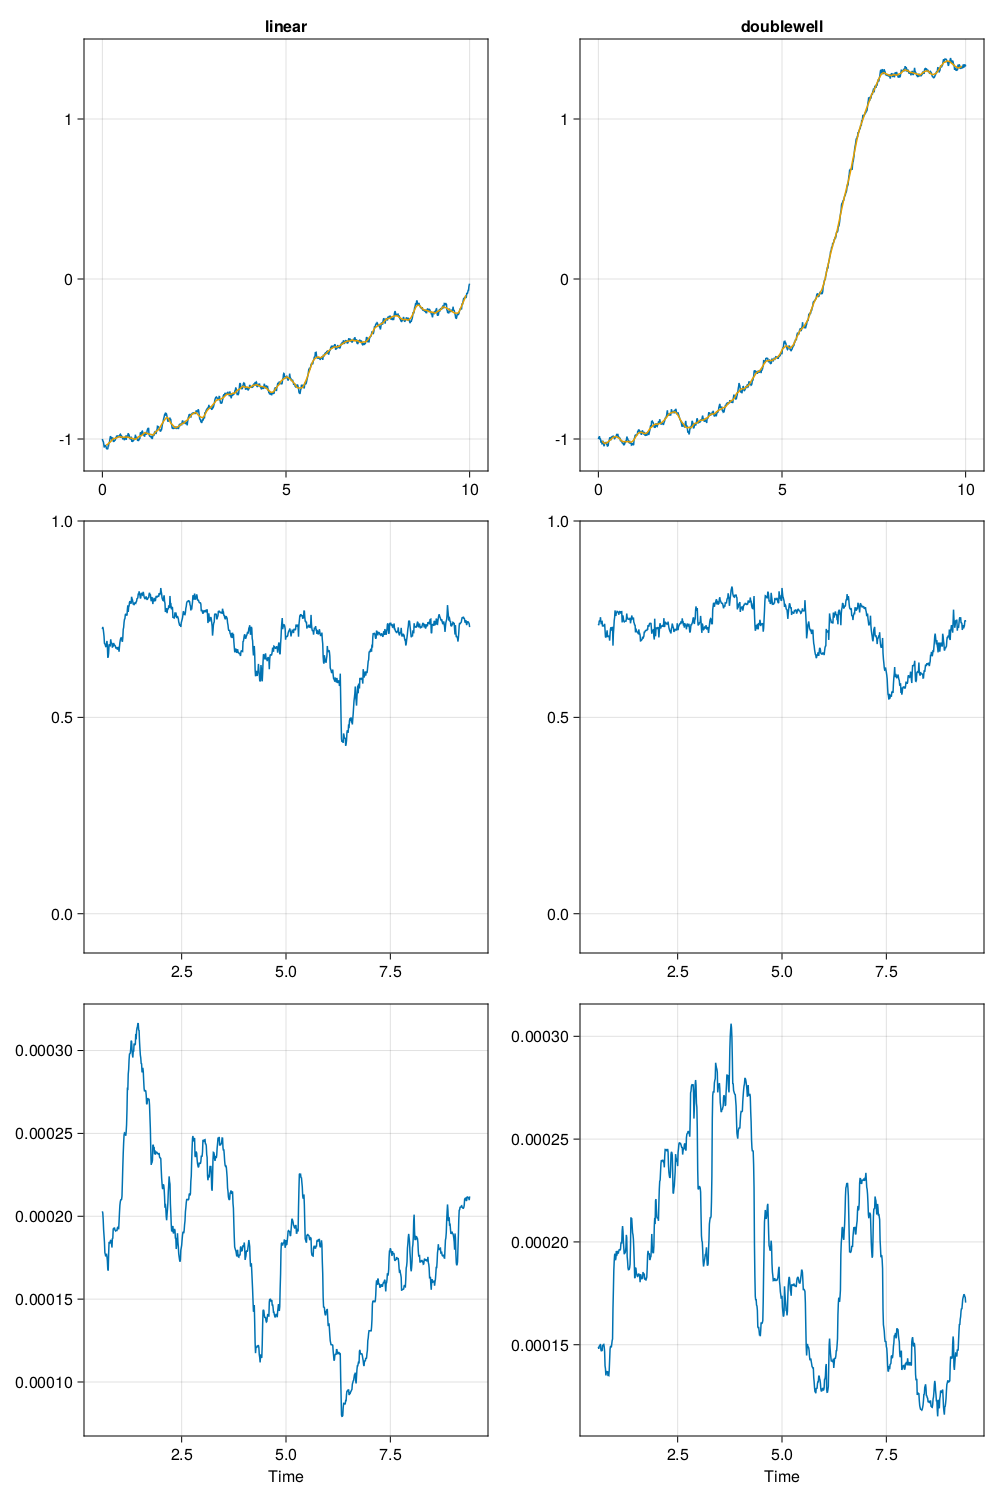

In [21]:
Xres_cpu = X .- Xtrend
var_cpu = slide_estimator( Xres_cpu, pwin.Nindctr, variance )
ar1_cpu = slide_estimator( Xres_cpu, pwin.Nindctr, ar1_whitenoise )

[lines!(axs[2][j], t, ar1_cpu[j, :], label = "ar1_cpu") for j in 1:ncols]
[ylims!(axs[2][i], (-.1, 1)) for i in 1:ncols]
[lines!(axs[3][j], t, var_cpu[j, :], label = "var_cpu") for j in 1:ncols]
fig

## Statistical significance

As we can observe in the previous plot, the critical transition of the double-well system in fact leads to an increase of the TIs!.. But such an increase also happens on the linear system, where no critical transition is possible. Meh. This means that along with true positives, we also want to get false ones.

Our way out of producing false positives is to test statistical significance by:
- Generating Fourier surrogates of the time series.
- Compute the transition indicator on each of these surrogates.
- Compute a metric that renders an increase of this indicator.
- Compare the increase metric of our actual time series with the ones computed on the surrogates.

The last step allows us to better investigate whether the increase of the TI is an artefact or not.

#### Fourier surrogates

Getting more data can be expensive (e.g. run a large model) or even barely possible (e.g. gather real-world data of the Earth system). However, (Fourier) surrogates of a given time series can be generated by:
- computing the Fourier transform of the time series.
- apply a random phase shift to each frequency.
- compute the inverse transform of the shifted spectrum.

To understand this with a simple example, one can imagine to have a time series x(t) given by:

$$ x(t) = \sin(t) + \sin(2 \pi \, t + \pi) $$

A Fourier surrogate of this could be:

$$ x_s(t) = \sin(t + 0.4 \, \pi) + \sin(2 \pi \, t + 2.7 \, \pi) $$

To generate such surrogates, TransitionIndicators.jl provides a ready-to-use function:

In [22]:
ns = 10000
S = fourier_surrogates(X, ns)

2×1001×10000 Array{Float64, 3}:
[:, :, 1] =
 0.287635  0.254569  0.272429  0.258647  …  0.224096  0.311932  0.323124
 0.86677   0.963401  1.1152    1.0613       1.10173   0.938999  0.94688

[:, :, 2] =
 -0.264503  -0.273672  -0.304708  …  -0.199044  -0.214634  -0.293854
 -1.28468   -1.36476   -1.33617      -1.17915   -1.15422   -1.24892

[:, :, 3] =
 -0.156913  -0.172459  -0.160422  …  -0.190144  -0.220723  -0.195123
  0.430573   0.354883   0.416734      0.557148   0.507503   0.47305

;;; … 

[:, :, 9998] =
  0.23475    0.233773   0.236165  …   0.274643   0.264882   0.270363
 -0.743235  -0.774216  -0.762154     -0.846029  -0.758467  -0.742848

[:, :, 9999] =
 0.0543335  0.0833413  0.0650642  0.0731506  …  0.163357  0.138685  0.0700475
 0.934944   0.853513   0.888061   0.880569      0.964473  0.905663  0.973484

[:, :, 10000] =
 -0.0943328  -0.0978097  -0.119661  …  -0.0161181  0.0183161  -0.0403215
  0.103571    0.167893    0.182135      0.0836169  0.0396185   0.0762178

#### Compute surrogate TIs

We can now perform the computation of the TIs by simply using:

In [23]:
STI = slide_estimator( S, pwin.Nindctr, ar1_whitenoise )

2×1001×10000 Array{Float64, 3}:
[:, :, 1] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

[:, :, 2] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

[:, :, 3] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

;;; … 

[:, :, 9998] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

[:, :, 9999] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

[:, :, 10000] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN 

Ouch. 10 000 surrogates is quite substantial and implies large dimension of the 3D surrogate array which in turn (surprise, surprise) leads to large computational cost. Moreover, the present case handles only two time series but applications sometimes present thousands of them (e.g. resulting from a 100 x 100 2D field). We might need something that scales better!

#### GPU accelerated TI computation

Some operations can be efficiently parallelised on GPUs. For high dimensionality, this can provide a significant speed-up, as e.g.:

In [53]:
ntest = 1000
Acpu = rand(ntest, ntest)
@benchmark $Acpu * $Acpu

BenchmarkTools.Trial: 529 samples with 1 evaluation.
 Range (min … max):  8.539 ms … 32.597 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.204 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.438 ms ±  1.523 ms  ┊ GC (mean ± σ):  0.40% ± 2.71%

   ▄▇▃▄▆█▂▃                                                   
  ▅████████▆▆▆▅▄▄▃▃▄▃▃▁▁▂▂▂▁▂▁▂▁▁▁▂▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂ ▃
  8.54 ms        Histogram: frequency by time        14.8 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 2.

In [54]:
Agpu = CUDA.rand(ntest, ntest)
@benchmark $Agpu * $Agpu

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   16.546 μs … 310.097 ms  ┊ GC (min … max): 0.00% … 2.43%
 Time  (median):     425.130 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   472.240 μs ±   6.378 ms  ┊ GC (mean ± σ):  0.80% ± 0.06%

  ▆▅▃▅           ▁▁ ▄█▄▂▁                                       ▂
  █████▆▁▁▄▁▃▁▁▁▄██▆█████▃▁▁▇▁▁▁▄▄▄▄▅▅▅██▇▄▃▃▄▁▃▃▄▄▄▄▆▆▅▇█████▇ █
  16.5 μs       Histogram: log(frequency) by time       1.32 ms <

 Memory estimate: 576 bytes, allocs estimate: 28.

For some TIs, a GPU-accelerated version of the computation has been implemented. This is the case for:
- Variance
- Skewness
- Kurtosis
- AR1 coefficient with white noise assumption

In [44]:
Sgpu = CuArray(S)
STIgpu = ar1_whitenoise(Sgpu, pwin)

2×1000×10000 Array{Float64, 3}:
[:, :, 1] =
 0.994158  0.996394  1.00101  …  0.998666  1.00348  1.00276  1.00827
 1.00127   1.00143   1.00167     1.00596   1.00656  1.00701  1.0087

[:, :, 2] =
 0.992167  0.992631  0.991449  0.990253  …  0.985734  0.988874  0.990227
 1.00674   1.00687   1.0069    1.00648      0.968503  0.968639  0.968521

[:, :, 3] =
 0.987556  0.988371  0.984211  …  1.00211  1.0037   1.00409  1.00592
 1.00043   1.0003    0.999753     1.01322  1.01372  1.01044  1.01015

;;; … 

[:, :, 9998] =
 0.98324  0.982433  0.987041  0.986846  …  1.00063  1.01031  1.00709  1.0061
 1.0047   0.99772   0.985051  0.988696     1.00654  1.00654  1.00853  1.00995

[:, :, 9999] =
 0.913444  0.913564  0.911914  0.911461  …  0.972689  0.968655  0.969909
 0.988455  0.990034  0.991769  0.990703     0.958862  0.960162  0.961414

[:, :, 10000] =
 0.926368  0.927727  0.935645  …  1.0023   1.0061   1.00678  1.01604
 0.977329  0.977298  0.976592     1.03879  1.04423  1.03312  1.03276

In [58]:
sum( (STIgpu[:, pwin.Nindctr+1:end-pwin.Nindctr, :] - STI[:, pwin.Nindctr+1:end-pwin.Nindctr-1, :]).^2 .> 1f-2 )

0

In [61]:
@benchmark slide_estimator( $S, $pwin.Nindctr, ar1_whitenoise )

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 27.138 s (22.35% GC) to evaluate,
 with a memory estimate of 75.79 GiB, over 90297026 allocations.

In [60]:
@benchmark ar1_whitenoise( $Sgpu, $pwin )

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  571.386 ms … 652.548 ms  ┊ GC (min … max): 1.43% … 4.45%
 Time  (median):     618.723 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   615.015 ms ±  26.514 ms  ┊ GC (mean ± σ):  1.44% ± 2.01%

  ▁               ▁    █             ▁ ▁     ▁              ▁ ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█ ▁
  571 ms           Histogram: frequency by time          653 ms <

 Memory estimate: 335.71 MiB, allocs estimate: 884497.

The CPU function needs about 27 seconds to run, whereas the GPU roughly needs 600 miliseconds, leading to a roughly estimated speed-up of factor 45. The absolute values are of course machine-specific and you might observed different ones, however the speed-up factor should be in the similar.